# Web scraper investigator

In [183]:
import requests
import pandas as pd
from bs4 import BeautifulSoup


def filter(string, substr):
    return [str for str in string if any(sub in str for sub in substr)]


def extract_kookai_data(clothing_item, page_no):
    clothing_page_url = (
        f"https://www.kookai.com.au/collections/{clothing_item}?page={page_no}"
    )

    r = requests.get(clothing_page_url, headers=headers)
    soup = BeautifulSoup(r.content, "lxml")

    name = soup.find_all("h3")
    price = soup.find_all("p")
    img = soup.find_all("img")
    total = soup.find_all("a")

    # Clothing item name
    known_clothing_item_names = [
        x.get_text() for x in name if "Notify Me" not in x.get_text()
    ]

    # Clothing item prices
    known_clothing_item_prices = [
        x.get_text() for x in price if "." in x.get_text() and "$" in x.get_text()
    ]

    # Clothing item colour (as given by Kookai)
    href_colours = ["-".join(x.lower().split(" ")) for x in known_clothing_item_names]
    colour_extrapolation = [x["href"] for x in total]
    filtered_colours = filter(colour_extrapolation, href_colours)

    data = []
    i = 0
    for image in img:
        if image["alt"] in known_clothing_item_names:
            product_name = image["alt"]
            product_price = known_clothing_item_prices[i]
            product_image = image["src"].replace("width=50", "width=500")[2::]
            try:
                # Colour if can be extracted
                known_item_to_link = "-".join(image["alt"].split(" ")).lower()
                if known_item_to_link not in href_colours[i]:
                    product_colour = None
                else:
                    product_colour = (
                        filtered_colours[i]
                        .replace(href_colours[i], "")
                        .replace("/products/-", "")
                        .replace("/products/", "")
                        .replace("-", " ")
                        .title()
                    )
                i += 1
            except IndexError:
                product_colour = None

            data.append(
                [
                    clothing_item,
                    page_no,
                    product_name,
                    product_price,
                    product_colour,
                    product_image,
                ]
            )

            # print("--")
            # print("product:", product_name)
            # print("image:", product_image)
            # print("price:", product_price)
            # print("colour:", product_colour)
    return data


clothing_items = [
    "dresses",
    "tops",
    "bottoms",
    "jackets",
    "sleepwear-lingerie",
    "sale",
    "new-arrivals",
]

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.54 Safari/537.36"
}
url = "https://www.kookai.com.au/collections/"

full_kookai_dataset = []
for clothing_item in clothing_items:
    for page_no in range(1, 10):
        kookai_subset = extract_kookai_data(clothing_item, page_no)
        full_kookai_dataset += kookai_subset

In [184]:
full_kookai_dataset_df = pd.DataFrame(
    full_kookai_dataset,
    columns=[
        "product_type",
        "website_page_no",
        "product_name",
        "product_price",
        "product_colour",
        "product_image",
    ],
)
full_kookai_dataset_df.sort_values(
    ["product_type", "product_name", "product_colour", "product_price"]
)
full_kookai_dataset_df[full_kookai_dataset_df["product_type"].notna()]

,product_type,website_page_no,product_name,product_price,product_colour,product_image
0,dresses,1,Mimi Mini Dress,$110.00,Coconut Milk,www.kookai.com.au/cdn/shop/files/P371_MIMIMINI...
1,dresses,1,Maddy Bead Dress,$170.00,Black,www.kookai.com.au/cdn/shop/files/RJ102_MADDIBE...
2,dresses,1,Tayla Trim Maxi Dress,$160.00,Coconut Milk,www.kookai.com.au/cdn/shop/files/Z2748_TAYLATR...
3,dresses,1,Savannah Mini Dress,$110.00,Blue Ice,www.kookai.com.au/cdn/shop/files/C178_SAVANNAH...
4,dresses,1,Nolan Mini Dress,$110.00,Black,www.kookai.com.au/cdn/shop/files/nolanminidres...
...,...,...,...,...,...,...
391,new-arrivals,3,Alia Core Top,$130.00,Vintage Khaki,www.kookai.com.au/cdn/shop/files/KT3997_ALIA_C...
392,new-arrivals,3,Ezra Jean,$150.00,Dark Indigo,www.kookai.com.au/cdn/shop/files/EZRAJEAN_DARK...
393,new-arrivals,3,Lola Sleeveless Top,$100.00,Black,www.kookai.com.au/cdn/shop/files/KK2989_LOLASL...
394,new-arrivals,3,Lola Sleeveless Top,$100.00,Lemon Meringue,www.kookai.com.au/cdn/shop/files/KK2989_LOLASL...


## How to download images

In [223]:
image_url = "https://" + full_kookai_dataset_df["product_image"][1]

img_data = requests.get(image_url).content
with open("test_image1.jpg", "wb") as handler:
    handler.write(img_data)

# Gen AI experimentation

In [196]:
import torch
from torchvision import transforms
from transformers import SamModel, SamProcessor
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid
import matplotlib.pyplot as plt

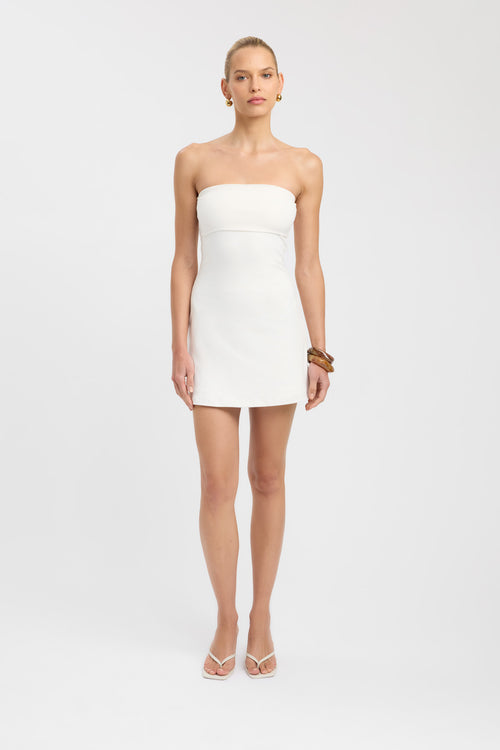

In [194]:
# load image
img = load_image("test_image.jpg")

# display image
img

In [202]:
model = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-50")
processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-50")

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [210]:
input_points = [[[250, 300]]]  # input point for object selection

inputs = processor(img, input_points=input_points, return_tensors="pt")
outputs = model(**inputs)
masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu(),
)

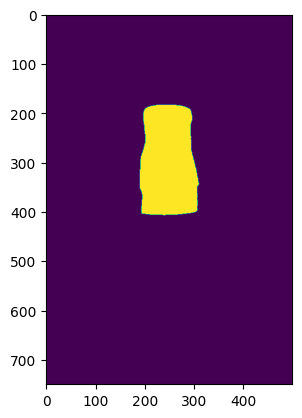

In [213]:
len(masks[0][0])
plt.imshow(masks[0][0][2])

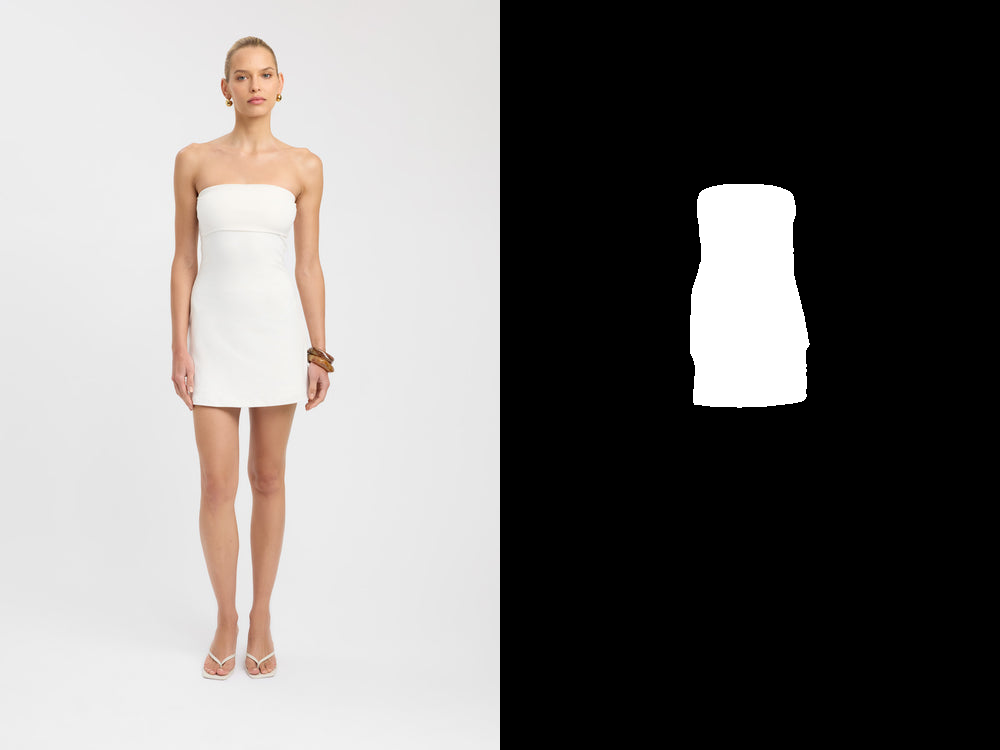

In [214]:
# Create a ToPILImage transform
to_pil = transforms.ToPILImage()

# Convert boolean tensors to binary tensors
binary_matrix_1 = masks[0][0][2].to(dtype=torch.uint8)

# apply the transform to the tensors
mask_1 = to_pil(binary_matrix_1 * 255)

# display original image with masks
make_image_grid([img, mask_1], cols=2, rows=1)

In [215]:
# create inpainting pipeline
pipeline = AutoPipelineForInpainting.from_pretrained(
    "redstonehero/ReV_Animated_Inpainting", torch_dtype=torch.float16
)

# pipeline.enable_model_cpu_offload()

model_index.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/Users/henrypierce/Library/Caches/pypoetry/virtualenvs/fashion-llm-VPw-D71b-py3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
An error occurred while trying to fetch /Users/henrypierce/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/henrypierce/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/Users/henrypierce/Library/Caches/pypoetry/vir

AssertionError: Torch not compiled with CUDA enabled

In [221]:
prompt = "red sundress, dress"

# generate image
image = pipeline(
    prompt=prompt,
    width=512,
    height=768,
    num_inference_steps=24,
    image=img,
    mask_image=mask_1,
    guidance_scale=3,
    strength=1.0,
).images[0]

# display input image and generated image
make_image_grid([img.resize([512, 768]), image], rows=1, cols=2)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
## Need to have way to style things together:

# Dress
# Top + Bottom

# Can add jacket to all of these

# 1. Classify what you are wearing in photo.
# 2. Replace X?

# Have search bar where you can look up different fashion accesseries.
# Colour?
#